In [1]:
import os
import numpy as np
import music21 as m21
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
import time
from collections import Counter

np.random.seed(777)
us = m21.environment.UserSettings()

# us['musescoreDirectPNGPath']="/home/sirivasv/Downloads/MuseScore-3.4.2-x86_64.AppImage"
us['musescoreDirectPNGPath']='/home/sirivasv/.local/bin/MuseScore-3.5.2.312125617-x86_64.AppImage'

# Define dataset paths
# MXML_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/mid"
MXML_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/mid"

# METADATA_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/metadata"
METADATA_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/metadata" 

# BSpline Results file path
BSPLINE_RESULST_PATH = "/home/sirivasv/Documents/projects/MelodyShape/src/results.txt"

In [2]:
def get_mean_distance_for_song():
    
    # We initialize the mean difference across noises
    diff_x_noises = []
    
    # Metric Values
    metric_values = []
    
    # Difference per percentage
    differences_per_percentage = []
    
    # We traverse the noises
    for noise_type_i in noise_types:
        # if (noise_type_i == 2):
            # continue
        
        # We initialize the mean distance in the current noise
        sorted_distance_mean_current_noise = 0
        
        # We save the similarities differences with the percentage
        similarity_differences_for_mean = []
        
        # We save metric values per noise type
        metric_values_per_noise = []
        
        # We save the values to sort accordingly their position
        metric_values_to_sort_percentage = []
        
        # We traverse the percentages
        for noise_percentage_i in noise_percentages:
            keyname_result = str(noise_type_i) + "_" + str(noise_percentage_i)
            # print(keyname_result)
            current_similarity = 1.0 - raw_BSPLINE_results_LOADED[keyname_result]
            # print(current_similarity)
            metric_values_per_noise.append(current_similarity)
            metric_values_to_sort_percentage.append(current_similarity)
                
        for nid, noise_percentage_i in enumerate(noise_percentages):
            noise_percentage_i /= 100.0
            similarity_differences_for_mean.append(np.abs(metric_values_to_sort_percentage[nid] - noise_percentage_i))
        
        # Get the mean of the 
        similarity_difference_mean_current_noise = np.mean(similarity_differences_for_mean)
        
        # Save the differences per percentage
        differences_per_percentage.append(similarity_differences_for_mean)
        
        # Save the metric values per percentage
        metric_values.append(metric_values_per_noise)
        
        # We sum the distance for this noise
        diff_x_noises.append(similarity_difference_mean_current_noise)
    
    # We return the mean distance per noise
    return metric_values, differences_per_percentage, diff_x_noises

## No Threshold

In [3]:
raw_BSPLINE_results_LOADED = {}
with open(BSPLINE_RESULST_PATH) as json_file:
    raw_BSPLINE_results_LOADED = json.load(json_file)

In [4]:
%%time
# Define noise type array
noise_types = [1, 2, 3, 4, 5]
len_noise_types = len(noise_types)

# Define the percentages of noise
noise_percentages = list(map(int, np.linspace(10, 100, 10)))

# TEST
metric_values_no_thd, differences_per_percentage_no_thd, diff_x_noises_no_thd = get_mean_distance_for_song()

CPU times: user 196 µs, sys: 26 µs, total: 222 µs
Wall time: 214 µs


In [5]:
print(np.mean(diff_x_noises_no_thd))

0.3459864342


## Graphs

In [6]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [7]:
def plot_conf_noises(metric_values_, differences_percentages_, diff_x_noises_):
    fig, axs = plt.subplots(7, 1, figsize=(12, 6 * 7))
    # print(differences_percentages_)
    
    # Graphs per noise type
    for noise_i in range(len_noise_types):
        axs_to_plot = axs[noise_i]
        rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), differences_percentages_[noise_i])
        autolabel(rects, axs_to_plot)
        axs_to_plot.set_title(label="Noise #" + str(noise_i + 1))
    
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[5]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noise accross percentages
    axs_to_plot = axs[6]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")
        

In [8]:
def get_mean_diff_vectors(differences_percentages_):
    # Get Mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    return grouped_percentage_values, list(map(np.mean, differences_percentages_))

In [9]:
def plot_conf_best_noises(raw_calculations):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6 * 2))
    differences_percentages_ = raw_calculations[1]
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[0]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noisea accross percentages
    axs_to_plot = axs[1]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")

## Experiment results

In [10]:
%%time

mad_and_std_per_noise_and_percentage = {}

metric_values_no_thd, differences_per_percentage_no_thd, diff_x_noises_no_thd = get_mean_distance_for_song()

per_percentage_mean_diffs, per_noise_mean_diffs = get_mean_diff_vectors(differences_per_percentage_no_thd)
mad_and_std_per_noise_and_percentage["noise"] = (
    stats.median_abs_deviation(per_noise_mean_diffs),
    np.std(per_noise_mean_diffs, dtype=np.float64),
    np.mean(per_noise_mean_diffs)
)
print(mad_and_std_per_noise_and_percentage["noise"])
mad_and_std_per_noise_and_percentage["percentage"] = (
    stats.median_abs_deviation(per_percentage_mean_diffs),
    np.std(per_percentage_mean_diffs, dtype=np.float64),
    np.mean(per_percentage_mean_diffs)
)
print(mad_and_std_per_noise_and_percentage["percentage"])
mad_and_std_per_noise_and_percentage["raw"] = (
    metric_values_no_thd,
    differences_per_percentage_no_thd,
    diff_x_noises_no_thd
)

(0.026173695000000052, 0.10907697537939427, 0.3459864342)
(0.08950785000000003, 0.08849333045956843, 0.3459864342)
CPU times: user 1.28 ms, sys: 158 µs, total: 1.43 ms
Wall time: 1.06 ms


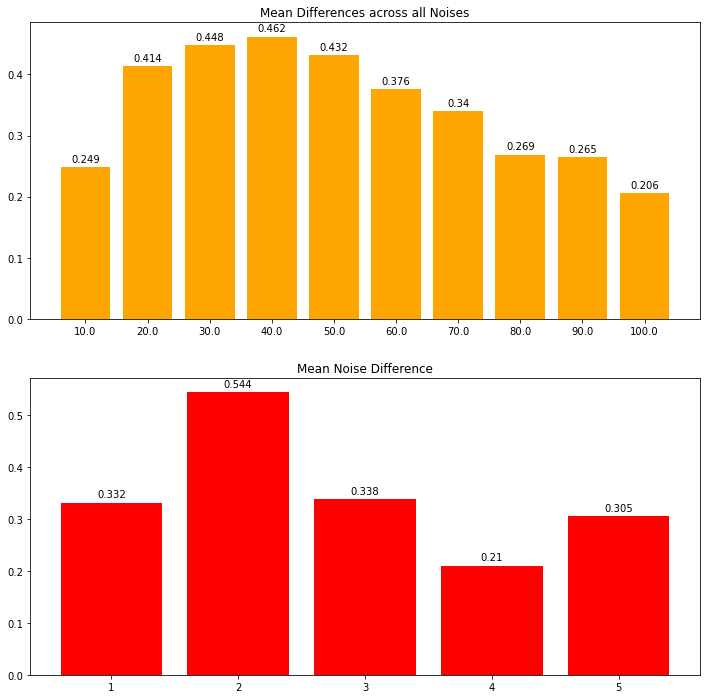

In [11]:
plot_conf_best_noises(mad_and_std_per_noise_and_percentage["raw"])